## Dependencies

In [1]:
import os
import sys
import cv2
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras import backend as K
from keras.models import Model
from keras.utils import to_categorical
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler, ModelCheckpoint

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(0)

seed = 0
seed_everything(seed)
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
sys.path.append(os.path.abspath('../input/efficientnet/efficientnet-master/efficientnet-master/'))
from efficientnet import *

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Load data

In [2]:
fold_set = pd.read_csv('../input/aptos-split-oldnew-balanced/5-fold.csv')
X_train = fold_set[fold_set['fold_3'] == 'train']
X_val = fold_set[fold_set['fold_3'] == 'validation']
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

# Preprocecss data
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")

print('Number of train samples: ', X_train.shape[0])
print('Number of validation samples: ', X_val.shape[0])
print('Number of test samples: ', test.shape[0])
display(X_train.head())

Number of train samples:  11665
Number of validation samples:  732
Number of test samples:  1928


,id_code,diagnosis,data,fold_0,fold_1,fold_2,fold_3,fold_4
0,40576_left.jpeg,0,old,train,train,train,train,train
1,33112_left.jpeg,0,old,train,train,train,train,train
2,31961_right.jpeg,0,old,train,train,train,train,train
3,2515_left.jpeg,0,old,train,train,train,train,train
4,40364_right.jpeg,0,old,train,train,train,train,train


# Model parameters

In [3]:
# Model parameters
model_path = '../working/effNetB5_img224_noBen_fold4.h5'
FACTOR = 4
BATCH_SIZE = 8 * FACTOR
WARMUP_EPOCHS = 5
EPOCHS = 20
LEARNING_RATE = 1e-4 * FACTOR
WARMUP_LEARNING_RATE = 1e-3 * FACTOR
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
TTA_STEPS = 5
ES_PATIENCE = 5
LR_WARMUP_EPOCHS = 3
STEP_SIZE = len(X_train) // BATCH_SIZE
TOTAL_STEPS = EPOCHS * STEP_SIZE
WARMUP_STEPS = LR_WARMUP_EPOCHS * STEP_SIZE

# Pre-procecess images

In [4]:
old_data_base_path = '../input/diabetic-retinopathy-resized/resized_train/resized_train/'
new_data_base_path = '../input/aptos2019-blindness-detection/train_images/'
test_base_path = '../input/aptos2019-blindness-detection/test_images/'
train_dest_path = 'base_dir/train_images/'
validation_dest_path = 'base_dir/validation_images/'
test_dest_path =  'base_dir/test_images/'

# Making sure directories don't exist
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)
    
# Creating train, validation and test directories
os.makedirs(train_dest_path)
os.makedirs(validation_dest_path)
os.makedirs(test_dest_path)

def crop_image(img, tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
            
        return img

def circle_crop(img):
    img = crop_image(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = width//2
    y = height//2
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image(img)

    return img
        
def preprocess_image(image_id, base_path, save_path, HEIGHT=HEIGHT, WIDTH=WIDTH, sigmaX=10):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = circle_crop(image)
    image = cv2.resize(image, (HEIGHT, WIDTH))
#     image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4 , 128)
    cv2.imwrite(save_path + image_id, image)
        
def preprocess_data(df, HEIGHT=HEIGHT, WIDTH=WIDTH, sigmaX=10):
    df = df.reset_index()
    for i in range(df.shape[0]):
        item = df.iloc[i]
        image_id = item['id_code']
        item_set = item['fold_3']
        item_data = item['data']
        if item_set == 'train':
            if item_data == 'new':
                preprocess_image(image_id, new_data_base_path, train_dest_path)
            if item_data == 'old':
                preprocess_image(image_id, old_data_base_path, train_dest_path)
        if item_set == 'validation':
            if item_data == 'new':
                preprocess_image(image_id, new_data_base_path, validation_dest_path)
            if item_data == 'old':
                preprocess_image(image_id, old_data_base_path, validation_dest_path)
        
def preprocess_test(df, base_path=test_base_path, save_path=test_dest_path, HEIGHT=HEIGHT, WIDTH=WIDTH, sigmaX=10):
    df = df.reset_index()
    for i in range(df.shape[0]):
        image_id = df.iloc[i]['id_code']
        preprocess_image(image_id, base_path, save_path)

n_cpu = mp.cpu_count()
train_n_cnt = X_train.shape[0] // n_cpu
val_n_cnt = X_val.shape[0] // n_cpu
test_n_cnt = test.shape[0] // n_cpu

# Pre-procecss old data train set
pool = mp.Pool(n_cpu)
dfs = [X_train.iloc[train_n_cnt*i:train_n_cnt*(i+1)] for i in range(n_cpu)]
dfs[-1] = X_train.iloc[train_n_cnt*(n_cpu-1):]
res = pool.map(preprocess_data, [x_df for x_df in dfs])
pool.close()

# Pre-procecss validation set
pool = mp.Pool(n_cpu)
dfs = [X_val.iloc[val_n_cnt*i:val_n_cnt*(i+1)] for i in range(n_cpu)]
dfs[-1] = X_val.iloc[val_n_cnt*(n_cpu-1):] 
res = pool.map(preprocess_data, [x_df for x_df in dfs])
pool.close()

# Pre-procecss test set
pool = mp.Pool(n_cpu)
dfs = [test.iloc[test_n_cnt*i:test_n_cnt*(i+1)] for i in range(n_cpu)]
dfs[-1] = test.iloc[test_n_cnt*(n_cpu-1):] 
res = pool.map(preprocess_test, [x_df for x_df in dfs])
pool.close()

# Data generator

In [5]:
datagen=ImageDataGenerator(rescale=1./255, 
                           rotation_range=360,
                           horizontal_flip=True,
                           vertical_flip=True)

train_generator=datagen.flow_from_dataframe(
                        dataframe=X_train,
                        directory=train_dest_path,
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="raw",
                        batch_size=BATCH_SIZE,
                        target_size=(HEIGHT, WIDTH),
                        seed=seed)

valid_generator=datagen.flow_from_dataframe(
                        dataframe=X_val,
                        directory=validation_dest_path,
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="raw",
                        batch_size=BATCH_SIZE,
                        target_size=(HEIGHT, WIDTH),
                        seed=seed)

test_generator=datagen.flow_from_dataframe(  
                       dataframe=test,
                       directory=test_dest_path,
                       x_col="id_code",
                       batch_size=1,
                       class_mode=None,
                       shuffle=False,
                       target_size=(HEIGHT, WIDTH),
                       seed=seed)

Found 11665 validated image filenames.
Found 732 validated image filenames.
Found 1928 validated image filenames.


In [6]:
def classify(x):
    if x < 0.5:
        return 0
    elif x < 1.5:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    return 4

labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
def plot_confusion_matrix(train, validation, labels=labels):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
    train_cnf_matrix = confusion_matrix(train_labels, train_preds)
    validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()
    
def plot_metrics(history, figsize=(20, 14)):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=figsize)

    ax1.plot(history['loss'], label='Train loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend(loc='best')
    ax1.set_title('Loss')

    ax2.plot(history['acc'], label='Train accuracy')
    ax2.plot(history['val_acc'], label='Validation accuracy')
    ax2.legend(loc='best')
    ax2.set_title('Accuracy')

    plt.xlabel('Epochs')
    sns.despine()
    plt.show()
    
def apply_tta(model, generator, steps=10):
    step_size = generator.n//generator.batch_size
    preds_tta = []
    for i in range(steps):
        generator.reset()
        preds = model.predict_generator(generator, steps=step_size)
        preds_tta.append(preds)

    return np.mean(preds_tta, axis=0)

def evaluate_model(train, validation):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    print("Train        Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_labels, weights='quadratic'))
    print("Validation   Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
    print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(np.append(train_preds, validation_preds), np.append(train_labels, validation_labels), weights='quadratic'))

def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """
    Cosine decay schedule with warm up period.
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.
    :param global_step {int}: global step.
    :param learning_rate_base {float}: base learning rate.
    :param total_steps {int}: total number of training steps.
    :param warmup_learning_rate {float}: initial learning rate for warm up. (default: {0.0}).
    :param warmup_steps {int}: number of warmup steps. (default: {0}).
    :param hold_base_rate_steps {int}: Optional number of steps to hold base learning rate before decaying. (default: {0}).
    :param global_step {int}: global step.
    :Returns : a float representing learning rate.
    :Raises ValueError: if warmup_learning_rate is larger than learning_rate_base, or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(Callback):
    """Cosine decay with warmup learning rate scheduler"""

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """
        Constructor for cosine decay with warmup learning rate scheduler.
        :param learning_rate_base {float}: base learning rate.
        :param total_steps {int}: total number of training steps.
        :param global_step_init {int}: initial global step, e.g. from previous checkpoint.
        :param warmup_learning_rate {float}: initial learning rate for warm up. (default: {0.0}).
        :param warmup_steps {int}: number of warmup steps. (default: {0}).
        :param hold_base_rate_steps {int}: Optional number of steps to hold base learning rate before decaying. (default: {0}).
        :param verbose {int}: quiet, 1: update messages. (default: {0}).
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %02d: setting learning rate to %s.' % (self.global_step + 1, lr))

# Model

In [7]:
def create_model(input_shape):
    input_tensor = Input(shape=input_shape)
    base_model = EfficientNetB5(weights=None, 
                                include_top=False,
                                input_tensor=input_tensor)
    base_model.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    final_output = Dense(1, activation='linear', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

# Train top layers

In [8]:
model = create_model(input_shape=(HEIGHT, WIDTH, CHANNELS))

for layer in model.layers:
    layer.trainable = False

for i in range(-2, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 112, 112, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [9]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=2).history

Epoch 1/5
 - 175s - loss: 1.4631 - acc: 0.3322 - val_loss: 1.6070 - val_acc: 0.2500
Epoch 2/5
 - 164s - loss: 1.1884 - acc: 0.3465 - val_loss: 2.5269 - val_acc: 0.3600
Epoch 3/5
 - 163s - loss: 1.2057 - acc: 0.3473 - val_loss: 1.4543 - val_acc: 0.1971
Epoch 4/5
 - 163s - loss: 1.1517 - acc: 0.3546 - val_loss: 2.0162 - val_acc: 0.1829
Epoch 5/5
 - 162s - loss: 1.1452 - acc: 0.3508 - val_loss: 2.1506 - val_acc: 0.3100


# Fine-tune the model

In [10]:
for layer in model.layers:
    layer.trainable = True
    
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
cosine_lr = WarmUpCosineDecayScheduler(learning_rate_base=LEARNING_RATE,
                                       total_steps=TOTAL_STEPS,
                                       warmup_learning_rate=0.0,
                                       warmup_steps=WARMUP_STEPS,
                                       hold_base_rate_steps=(2 * STEP_SIZE))

callback_list = [checkpoint, es, cosine_lr]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 112, 112, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [11]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callback_list,
                              verbose=2).history

Epoch 1/20
 - 358s - loss: 1.0227 - acc: 0.3825 - val_loss: 0.4892 - val_acc: 0.6171
Epoch 2/20
 - 312s - loss: 0.8235 - acc: 0.4342 - val_loss: 0.3900 - val_acc: 0.6071
Epoch 3/20
 - 313s - loss: 0.6914 - acc: 0.4739 - val_loss: 0.2972 - val_acc: 0.7986
Epoch 4/20
 - 312s - loss: 0.6347 - acc: 0.4977 - val_loss: 0.2626 - val_acc: 0.7829
Epoch 5/20
 - 312s - loss: 0.5787 - acc: 0.5176 - val_loss: 0.2980 - val_acc: 0.7229
Epoch 6/20
 - 313s - loss: 0.5438 - acc: 0.5410 - val_loss: 0.2723 - val_acc: 0.8100
Epoch 7/20
 - 312s - loss: 0.5192 - acc: 0.5495 - val_loss: 0.2602 - val_acc: 0.7543
Epoch 8/20
 - 313s - loss: 0.4918 - acc: 0.5599 - val_loss: 0.2382 - val_acc: 0.7686
Epoch 9/20
 - 312s - loss: 0.4768 - acc: 0.5668 - val_loss: 0.2318 - val_acc: 0.8343
Epoch 10/20
 - 313s - loss: 0.4559 - acc: 0.5795 - val_loss: 0.2248 - val_acc: 0.8343
Epoch 11/20
 - 312s - loss: 0.4164 - acc: 0.5959 - val_loss: 0.2098 - val_acc: 0.8071
Epoch 12/20
 - 313s - loss: 0.3894 - acc: 0.6144 - val_loss: 0.

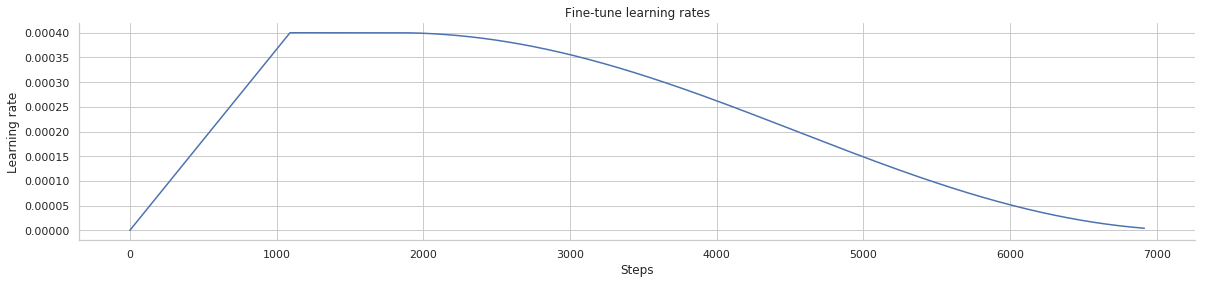

In [12]:
fig, ax = plt.subplots(1, 1, sharex='col', figsize=(20, 4))

ax.plot(cosine_lr.learning_rates)
ax.set_title('Fine-tune learning rates')

plt.xlabel('Steps')
plt.ylabel('Learning rate')
sns.despine()
plt.show()

# Model loss graph 

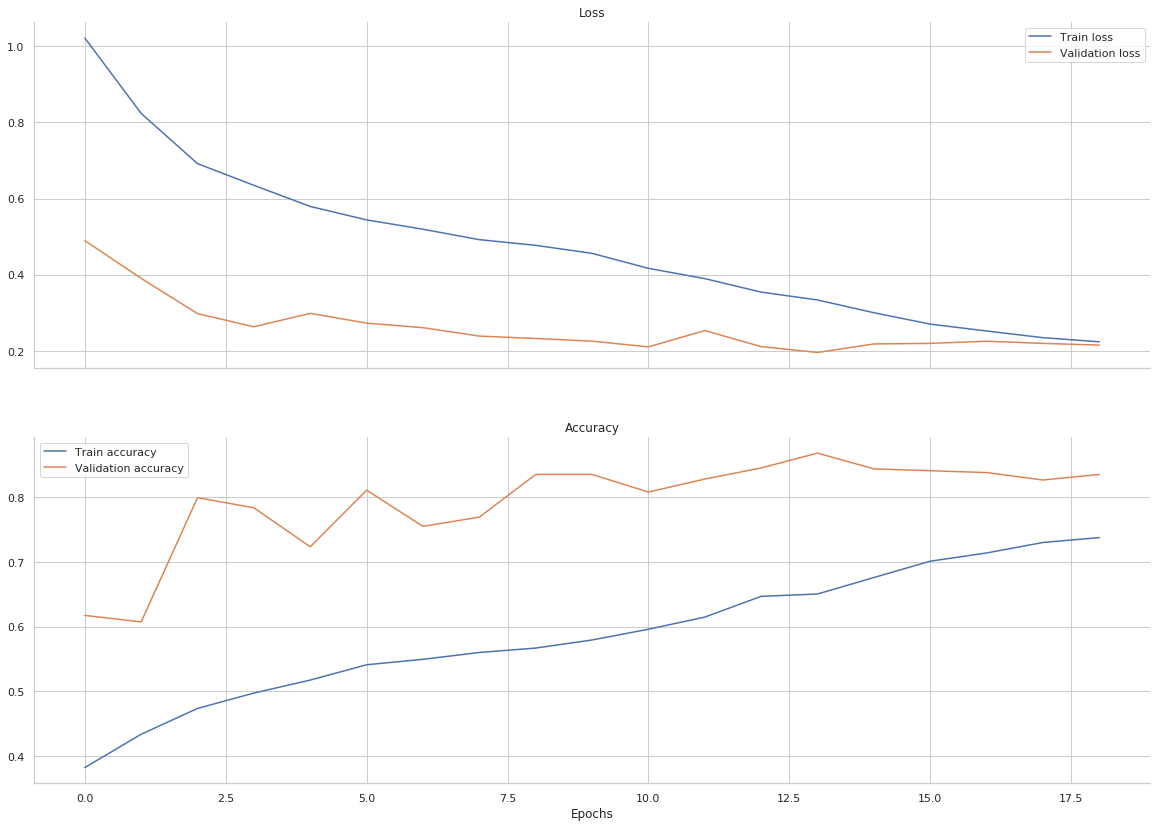

In [13]:
plot_metrics(history)

In [14]:
# Create empty arays to keep the predictions and labels
df_preds = pd.DataFrame(columns=['label', 'pred', 'set'])
train_generator.reset()
valid_generator.reset()

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN + 1):
    im, lbl = next(train_generator)
    preds = model.predict(im, batch_size=train_generator.batch_size)
    for index in range(len(preds)):
        df_preds.loc[len(df_preds)] = [lbl[index], preds[index][0], 'train']

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID + 1):
    im, lbl = next(valid_generator)
    preds = model.predict(im, batch_size=valid_generator.batch_size)
    for index in range(len(preds)):
        df_preds.loc[len(df_preds)] = [lbl[index], preds[index][0], 'validation']

df_preds['label'] = df_preds['label'].astype('int')

In [15]:
# Classify predictions
df_preds['predictions'] = df_preds['pred'].apply(lambda x: classify(x))

train_preds = df_preds[df_preds['set'] == 'train']
validation_preds = df_preds[df_preds['set'] == 'validation']

# Model Evaluation

## Confusion Matrix

### Original thresholds

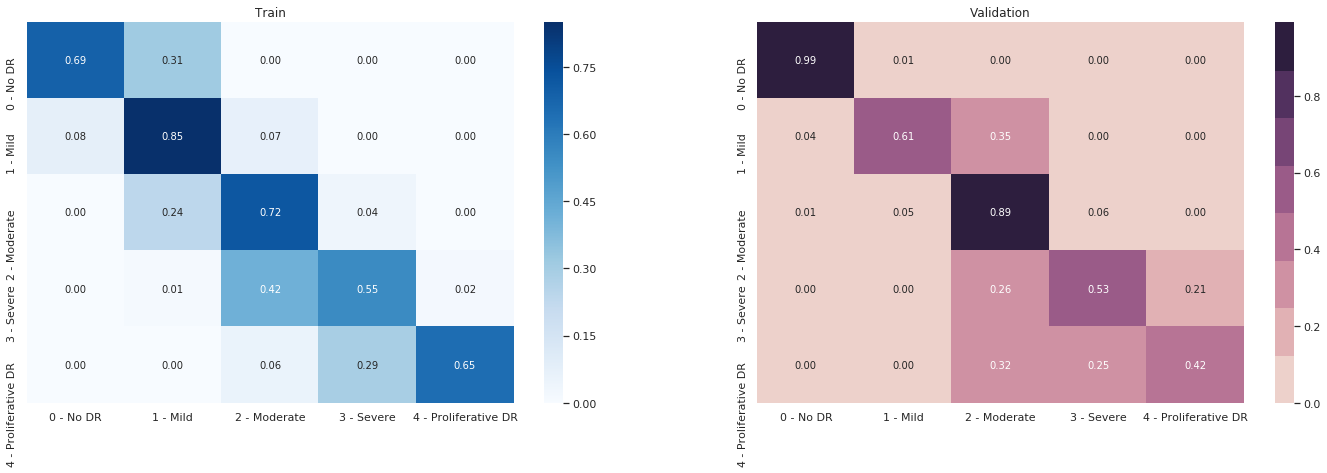

In [16]:
plot_confusion_matrix((train_preds['label'], train_preds['predictions']), (validation_preds['label'], validation_preds['predictions']))

## Quadratic Weighted Kappa

In [17]:
evaluate_model((train_preds['label'], train_preds['predictions']), (validation_preds['label'], validation_preds['predictions']))

Train        Cohen Kappa score: 0.888
Validation   Cohen Kappa score: 0.928
Complete set Cohen Kappa score: 0.891


## Apply model to test set and output predictions

In [18]:
preds = apply_tta(model, test_generator, TTA_STEPS)
predictions = [classify(x) for x in preds]

results = pd.DataFrame({'id_code':test['id_code'], 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

In [19]:
# Cleaning created directories
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)

# Predictions class distribution

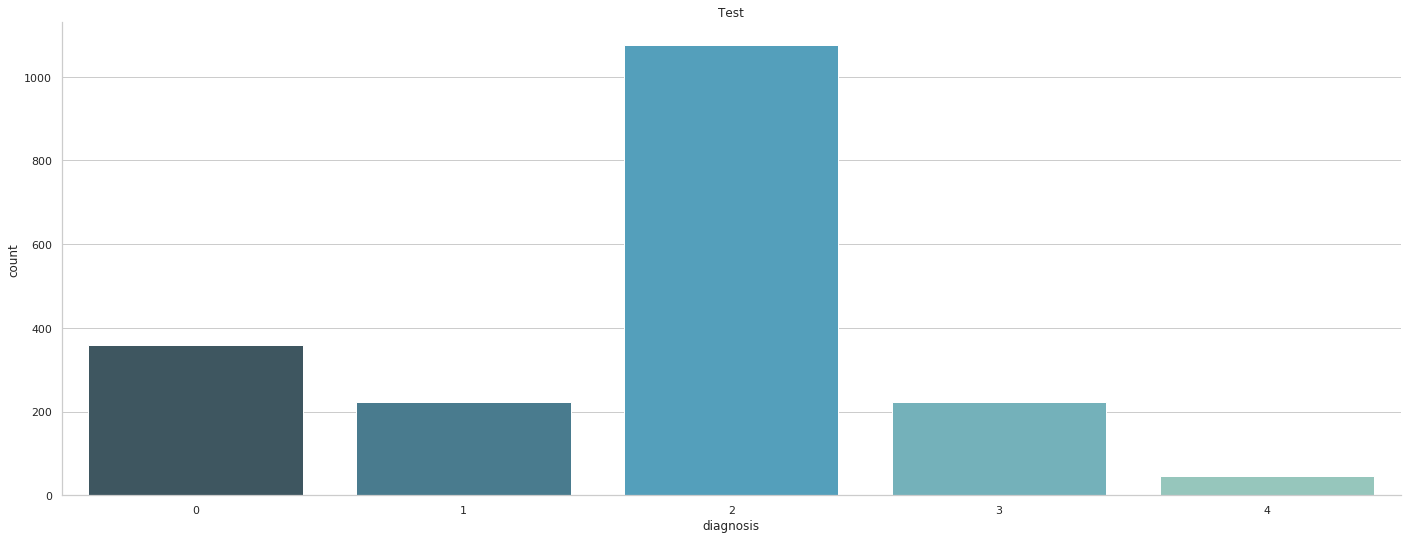

In [20]:
fig = plt.subplots(sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d").set_title('Test')
sns.despine()
plt.show()

In [21]:
results.to_csv('submission.csv', index=False)
display(results.head())

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,1
4,009245722fa4,2
